# Project 1 - ResNet Ablation Study

### 목표
- **ResNet-34, ResNet-50 모델 구현**
- **Cats vs Dogs 데이터셋으로 Image Classification 모델 훈련**
- **plain 모델과 residual 모델을 통한 Ablation Study**

### (1) Cats vs Dogs 데이터셋 준비

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

c:\Users\JDINO\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
setattr(
    tfds.image_classification.cats_vs_dogs,
    '_URL',
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
)

In [3]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    data_dir='../tensorflow_datasets'
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})


In [5]:
# 데이터의 개수도 확인해 봅시다.
ds_train_num = int(tf.data.experimental.cardinality(ds_train))
ds_val_num = int(tf.data.experimental.cardinality(ds_val))
ds_test_num = int(tf.data.experimental.cardinality(ds_test))

print(ds_train_num)
print(ds_val_num)
print(ds_test_num)

16283
4653
2326


In [6]:
IMAGE_SHAPE = 224

In [7]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`.
    return tf.image.resize(tf.cast(image, tf.float32), (IMAGE_SHAPE, IMAGE_SHAPE)) / 255., label

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_info.features["label"].num_classes

2

In [10]:
ds_info.features["label"].names

['cat', 'dog']

### (2) 네트워크 블록 구성

In [11]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)
                # skip connection
                x = keras.layers.Add()([x,identity])
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)
            # skip connection
            x = keras.layers.Add()([x,identity])
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

In [12]:
def build_resnet(name,
              input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10, is_50 = False, is_plain = False):

    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]

    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)

    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i
        )
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)

    if num_classes == 1:
        output = keras.layers.Dense(num_classes, activation='sigmoid', name='predictions')(output)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

    model = keras.Model(
        inputs=input_layer,
        outputs=output,
        name=name
    )

    return model

### (3) ResNet Complete Model

In [13]:
BATCH_SIZE = 64
EPOCH = 30

In [14]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_val = apply_normalize_on_dataset(ds_val, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [15]:
print(ds_train)
print(ds_val)
print(ds_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [16]:
with tf.device('/GPU:0'):
# with strategy.scope():
    resnet_34 = build_resnet('ResNet-34', is_50 = False, num_classes=1)

    resnet_34.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
        metrics=['accuracy'],
    )

    resnet_34.summary()

Model: "ResNet-34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  832         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

In [17]:
with tf.device('/GPU:0'):
# with strategy.scope():
    resnet_50 = build_resnet('ResNet-50', is_50 = True, num_classes=1)

    resnet_50.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
        metrics=['accuracy'],
    )

    resnet_50.summary()

Model: "ResNet-50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 112, 112, 64  832         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 112, 112, 64  256        ['conv2d_4[0][0]']               
 ormalization)                  )                                                         

In [18]:
with tf.device('/GPU:0'):
# with strategy.scope():
    plain_resnet_34 = build_resnet('PlainResNet-34', is_50 = False, is_plain = True, num_classes=1)

    plain_resnet_34.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
        metrics=['accuracy'],
    )

    plain_resnet_34.summary()

Model: "PlainResNet-34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 112, 112, 64  832         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 112, 112, 64  256        ['conv2d_8[0][0]']               
 ormalization)                  )                                                    

In [19]:
with tf.device('/GPU:0'):
# with strategy.scope():
    plain_resnet_50 = build_resnet('PlainResNet-50', is_50 = True, is_plain = True, num_classes=1)

    plain_resnet_50.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
        metrics=['accuracy'],
    )

    plain_resnet_50.summary()

Model: "PlainResNet-50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 112, 112, 64  832         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_51 (BatchN  (None, 112, 112, 64  256        ['conv2d_12[0][0]']              
 ormalization)                  )                                                    

### (4) 모델 학습

In [20]:
with tf.device('/GPU:0'):
# with strategy.scope():
    history_34 = resnet_34.fit(
        ds_train,
        steps_per_epoch=int(ds_train_num/BATCH_SIZE),
        validation_steps=int(ds_val_num/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_val,
        verbose=1,
        use_multiprocessing=True,
    )

Epoch 1/30
254/254 [==============================] - 74s 161ms/step - loss: 1.1954 - accuracy: 0.5746 - val_loss: 0.6716 - val_accuracy: 0.5949
Epoch 2/30
254/254 [==============================] - 38s 148ms/step - loss: 0.8242 - accuracy: 0.6409 - val_loss: 0.6850 - val_accuracy: 0.6339
Epoch 3/30
254/254 [==============================] - 44s 173ms/step - loss: 0.6557 - accuracy: 0.6908 - val_loss: 0.6750 - val_accuracy: 0.6803
Epoch 4/30
254/254 [==============================] - 36s 144ms/step - loss: 0.5506 - accuracy: 0.7397 - val_loss: 0.7223 - val_accuracy: 0.6869
Epoch 5/30
254/254 [==============================] - 37s 144ms/step - loss: 0.4785 - accuracy: 0.7722 - val_loss: 0.6075 - val_accuracy: 0.7161
Epoch 6/30
254/254 [==============================] - 44s 174ms/step - loss: 0.4222 - accuracy: 0.8049 - val_loss: 0.6881 - val_accuracy: 0.6936
Epoch 7/30
254/254 [==============================] - 36s 144ms/step - loss: 0.3821 - accuracy: 0.8280 - val_loss: 0.5337 - val_ac

In [21]:
with tf.device('/GPU:0'):
# with strategy.scope():
    history_50 = resnet_50.fit(
        ds_train,
        steps_per_epoch=int(ds_train_num/BATCH_SIZE),
        validation_steps=int(ds_val_num/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_val,
        verbose=1,
        use_multiprocessing=True,
    )

Epoch 1/30
254/254 [==============================] - 56s 145ms/step - loss: 1.0889 - accuracy: 0.5792 - val_loss: 1.4335 - val_accuracy: 0.4993
Epoch 2/30
254/254 [==============================] - 36s 144ms/step - loss: 0.8089 - accuracy: 0.6319 - val_loss: 0.9954 - val_accuracy: 0.5295
Epoch 3/30
254/254 [==============================] - 36s 143ms/step - loss: 0.6497 - accuracy: 0.6842 - val_loss: 0.5770 - val_accuracy: 0.7081
Epoch 4/30
254/254 [==============================] - 36s 144ms/step - loss: 0.5558 - accuracy: 0.7276 - val_loss: 0.6757 - val_accuracy: 0.6723
Epoch 5/30
254/254 [==============================] - 44s 173ms/step - loss: 0.4871 - accuracy: 0.7652 - val_loss: 0.5681 - val_accuracy: 0.7214
Epoch 6/30
254/254 [==============================] - 36s 143ms/step - loss: 0.4422 - accuracy: 0.7924 - val_loss: 0.5407 - val_accuracy: 0.7424
Epoch 7/30
254/254 [==============================] - 36s 143ms/step - loss: 0.3978 - accuracy: 0.8185 - val_loss: 0.7848 - val_ac

In [22]:
with tf.device('/GPU:0'):
# with strategy.scope():
    history_plain_34 = plain_resnet_34.fit(
        ds_train,
        steps_per_epoch=int(ds_train_num/BATCH_SIZE),
        validation_steps=int(ds_val_num/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_val,
        verbose=1,
        use_multiprocessing=True,
    )

Epoch 1/30
254/254 [==============================] - 57s 147ms/step - loss: 1.1411 - accuracy: 0.5915 - val_loss: 0.6904 - val_accuracy: 0.5742
Epoch 2/30
254/254 [==============================] - 37s 144ms/step - loss: 0.8600 - accuracy: 0.6408 - val_loss: 0.6142 - val_accuracy: 0.6880
Epoch 3/30
254/254 [==============================] - 44s 173ms/step - loss: 0.6869 - accuracy: 0.6835 - val_loss: 0.6387 - val_accuracy: 0.7087
Epoch 4/30
254/254 [==============================] - 36s 144ms/step - loss: 0.5831 - accuracy: 0.7229 - val_loss: 0.5873 - val_accuracy: 0.7267
Epoch 5/30
254/254 [==============================] - 37s 144ms/step - loss: 0.5027 - accuracy: 0.7619 - val_loss: 0.5924 - val_accuracy: 0.7256
Epoch 6/30
254/254 [==============================] - 37s 144ms/step - loss: 0.4363 - accuracy: 0.7960 - val_loss: 0.5308 - val_accuracy: 0.7522
Epoch 7/30
254/254 [==============================] - 37s 146ms/step - loss: 0.4038 - accuracy: 0.8134 - val_loss: 0.5986 - val_ac

In [23]:
with tf.device('/GPU:0'):
# with strategy.scope():
    history_plain_50 = plain_resnet_50.fit(
        ds_train,
        steps_per_epoch=int(ds_train_num/BATCH_SIZE),
        validation_steps=int(ds_val_num/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_val,
        verbose=1,
        use_multiprocessing=True,
    )

Epoch 1/30
254/254 [==============================] - 56s 145ms/step - loss: 1.1573 - accuracy: 0.5830 - val_loss: 0.7575 - val_accuracy: 0.5452
Epoch 2/30
254/254 [==============================] - 36s 143ms/step - loss: 0.8402 - accuracy: 0.6328 - val_loss: 1.3481 - val_accuracy: 0.5048
Epoch 3/30
254/254 [==============================] - 36s 144ms/step - loss: 0.6706 - accuracy: 0.6847 - val_loss: 0.7003 - val_accuracy: 0.6635
Epoch 4/30
254/254 [==============================] - 44s 173ms/step - loss: 0.5810 - accuracy: 0.7222 - val_loss: 0.6782 - val_accuracy: 0.6890
Epoch 5/30
254/254 [==============================] - 37s 144ms/step - loss: 0.5037 - accuracy: 0.7598 - val_loss: 0.5743 - val_accuracy: 0.7457
Epoch 6/30
254/254 [==============================] - 44s 174ms/step - loss: 0.4580 - accuracy: 0.7841 - val_loss: 0.6378 - val_accuracy: 0.7082
Epoch 7/30
254/254 [==============================] - 36s 144ms/step - loss: 0.4008 - accuracy: 0.8143 - val_loss: 0.5594 - val_ac

### (5) 모델 결과 비교

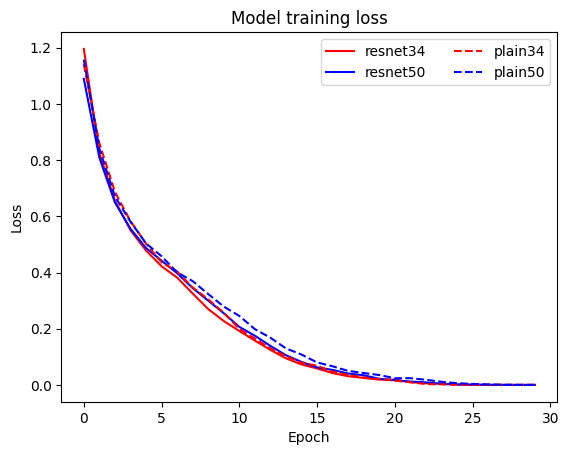

In [24]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'r', linestyle='--')
plt.plot(history_plain_50.history['loss'], 'b', linestyle='--')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50', 'plain34', 'plain50'], loc='upper right', ncol=2)
plt.show()

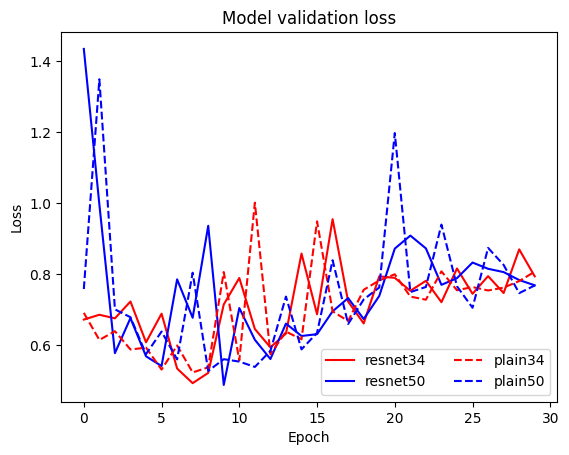

In [25]:
plt.plot(history_34.history['val_loss'], 'r')
plt.plot(history_50.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'r', linestyle='--')
plt.plot(history_plain_50.history['val_loss'], 'b', linestyle='--')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50', 'plain34', 'plain50'], loc='lower right', ncol=2)
plt.show()

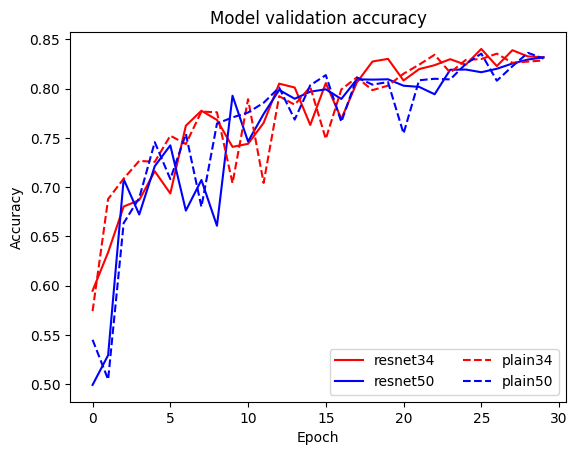

In [26]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'r', linestyle='--')
plt.plot(history_plain_50.history['val_accuracy'], 'b', linestyle='--')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50','plain34', 'plain50'], loc='lower right', ncol=2)
plt.show()

- resnet50, plain50이 accuracy가 더 높게 나타났다.
- deeper model에서 accuracy가 더 높다는 것을 알 수 있었다.

- 34 layers에서는 잘 나타나지 않았지만 50 layers에서는 plain보다 resnet이 더 accuracy가 높았다.
- resnet의 **skip connection**이 deeper model에서 **vanishing gradient** 문제를 해결함을 알 수 있었다